<a id="top"></a>
# Top


In [548]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

from scipy import stats

In [549]:

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

<a id="functions"></a>
## 1 Functions

In [788]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

In [789]:
def plot_hist_normalized(this_column, this_scaler: [str] = "standard_scaler"):
    if this_scaler == "power_transformator":
        pt = PowerTransformer()
        col_transformed_pt=pt.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_pt).set(title=f"{this_column.name} - PowerTransformer") 
    elif this_scaler == "quantile_transformer":
        qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
        col_transformed_qt=qt.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_qt).set(title=f"{this_column.name} - QuantileTransformer")
    else:
        sc = StandardScaler()
        col_transformed_sc=sc.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_sc).set(title=f"{this_column.name} - StandardScaler")

In [790]:
def boxplots_for_all_numerical_cols(this_df):
    fig, ax = plt.subplots(figsize=(10,10))
    len_num_lst = len(split_column_names_by(this_df)[0])
    i = 1
    for col in split_column_names_by(this_df)[0]:            
        plt.subplot(math.ceil(len_num_lst**.5),math.ceil(len_num_lst**.5),i)
        sns.boxplot(y=this_df[col]).set(title=f"{col}")
        i += 1

In [791]:
def split_df_by(this_df, include_dtypes:[list]=["int","float"]):
    """takes in this_df, splits it into two NEW DF's by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_df, excl_df)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (this_df[incl_lst], this_df[excl_lst])

In [792]:
def all_numeric_to_int(this_df):
    for col in this_df._get_numeric_data():
        this_df[col] = this_df[col].astype(np.int64)
    return this_df

In [793]:
def all_strings_lowercase(this_df):
    for col in this_df:
        this_df[col] = this_df[col].map(lambda x: x.lower() if isinstance(x,str) else x)
    return this_df

In [794]:
def nan_values_of_all_columns(this_df, return_dict:[bool] = False):
    """prints (defaults) or returns dictionary of all columns in this_df and their respective nan-values"""
    if not return_dict:
        for col in this_df.columns:
            print(col, this_df[col].isna().sum())
        return
    return {col:this_df[col].isna().sum() for col in this_df.columns}

In [795]:
def extract_year_month(this_date:[str]=None):
    # __author__ = "Roman Kaltschew"
    """takes this_date in format MM/DD/YYYY and returns YYYY_MM"""
    if this_date:
        return this_date.split("/")[2]+"_"+this_date.split("/")[0]
    return None

In [796]:
def extract_month(this_date:[str]=None, as_type:[str]=None):
    # __author__ = "Roman Kaltschew"
    """takes this_date in format MM/DD/YYYY and returns MM as_type (default str)"""
    if this_date:
        if as_type == "int":
            return int(this_date.split("/")[0])
        else:
            return str(this_date.split("/")[0])
    return None

In [797]:
def plot_long_lat():
    geometry = [Point(xy) for xy in zip(data['long'], data['lat'])]
    gdf = GeoDataFrame(df, geometry=geometry)   

    #this is a simple map that goes with geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)
    
    fig = px.scatter_geo(data,lat='lat',lon='long') #, hover_name="id")
    fig.update_layout(title = 'World map', title_x=0.5)
    fig.show()

[top of notebook](#top)

<a id='read_clean'></a>

## 2 Read and Clean

In [895]:
data = pd.read_csv("data/regression_data.csv")
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/2014,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/2014,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/2015,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/2014,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/2015,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


<a id="classifying_columns"></a>
### 2.1 Classifying columns

+ divide columns in numerical and discrete

In [896]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [1024]:
for col in ["id", "view", "condition", "grade", "lat", "long", "zipcode", "waterfront", "floors"]:
    data[col] = data[col].astype('category')

[top of notebook](#top)

<a id="numericals"></a>
### 2.2 Numericals

#### 2.2.1 Check for NaNs

In [1025]:
nan_values_of_all_columns(data[split_column_names_by(data)[0]])

bedrooms 0
bathrooms 0
sqft_living 0
sqft_lot 0
sqft_above 0
sqft_basement 0
yr_built 0
yr_renovated 0
sqft_living15 0
sqft_lot15 0
price 0


#### 2.2.2 Boxplots - check for outliers

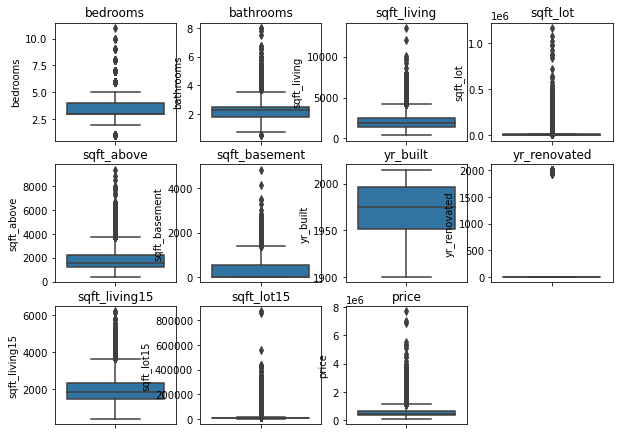

In [1026]:
boxplots_for_all_numerical_cols(data)

##### bedroom outlier

In [1027]:
data[data["bedrooms"] == max(data["bedrooms"])][["bedrooms","sqft_living"]]

,bedrooms,sqft_living
8748,11,3000


In [1028]:
print(f"Average living space of tree bedrooms: {round(np.mean(data[data['bedrooms']==3]['sqft_living']), 2)}")
print(f"Average living space of two bedrooms: {round(np.mean(data[data['bedrooms']==2]['sqft_living']), 2)}")

Average living space of tree bedrooms: 1805.82
Average living space of two bedrooms: 1239.75


+ it is likely, that the 33 is a typo, it will be changed to 3

In [1029]:
data.at[15856,"bedrooms"] = 3

##### sqft_lot outlier

In [1030]:
print(data[data["sqft_lot"] == max(data["sqft_lot"])][["bedrooms","sqft_lot"]])

       bedrooms  sqft_lot
17305         2   1164794


In [1031]:
print(f"Average lot in ft² of four bedrooms: {round(np.mean(data[data['bedrooms']==4]['sqft_lot']), 2)}")


Average lot in ft² of four bedrooms: 16483.24


+ it is likely, that a comma was forgotton, sqft_lot will be set to 16513.59

In [1032]:
data.at[1717,"sqft_lot"] = 16513.59

##### sqft_living

In [1033]:
# max sqft_living
data[data["sqft_living"] == max(data["sqft_living"])]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,month_sold
12764,1225069038,5/5/2014,7,8.0,13540,307752,3.0,0,4,3,...,4130,1999,0,98053,47.6675,-121.986,4850,217800,2280000,5


In [1034]:
# sqft_living > 10000
data[data["sqft_living"] > 10000]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,month_sold
3910,9808700762,6/11/2014,5,4.5,10040,37325,2.0,1,2,3,...,2360,1940,2001,98004,47.6500,-122.214,3930,25449,7060000,6
7245,6762700020,10/13/2014,6,8.0,12050,27600,2.5,0,3,4,...,3480,1910,1987,98102,47.6298,-122.323,3940,8800,7700000,10
12764,1225069038,5/5/2014,7,8.0,13540,307752,3.0,0,4,3,...,4130,1999,0,98053,47.6675,-121.986,4850,217800,2280000,5


consider dropping these for modelling, as they don't represent a "normal" property in this dataset

##### sqft_basement

In [1035]:
# max sqft_basement
data[data["sqft_basement"] == max(data["sqft_basement"])]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,month_sold
8085,1924059029,6/17/2014,5,6.75,9640,13068,1.0,1,4,3,...,4820,1983,2009,98040,47.557,-122.21,3270,10454,4670000,6


In [1036]:
print(f"Average sqft_basement of five bedrooms: {round(np.mean(data[data['bedrooms']==5]['sqft_basement']), 2)}")
print(f"Average sqft_above of five bedrooms: {round(np.mean(data[data['bedrooms']==5]['sqft_above']), 2)}")

Average sqft_basement of five bedrooms: 639.98
Average sqft_above of five bedrooms: 2407.57


**??????????????**

##### Next outlier

In [1037]:
(data[data["sqft_lot15"] == max(data["sqft_lot15"])])#[["bedrooms","sqft_lot"]])

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,month_sold
9705,225079036,1/7/2015,4,4.0,5545,871200,2.0,0,0,3,...,1940,2003,0,98014,47.676,-121.882,3420,871200,937500,1


In [1038]:
(data[data["sqft_lot15"] == max(data["sqft_lot15"])])#[["bedrooms","sqft_lot"]])

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,month_sold
9705,225079036,1/7/2015,4,4.0,5545,871200,2.0,0,0,3,...,1940,2003,0,98014,47.676,-121.882,3420,871200,937500,1


In [1039]:
data.sqft_lot15.value_counts()

5000     427
4000     356
6000     288
7200     210
4800     145
        ... 
10170      1
10573      1
11477      1
1449       1
2007       1
Name: sqft_lot15, Length: 8682, dtype: int64

##### Year renovated

In [1040]:
data["yr_renovated"].value_counts()  

0       20683
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

Unlikely, that most of the buildings were not renovated... drop column b/c incomplete

In [1041]:
# placeholder

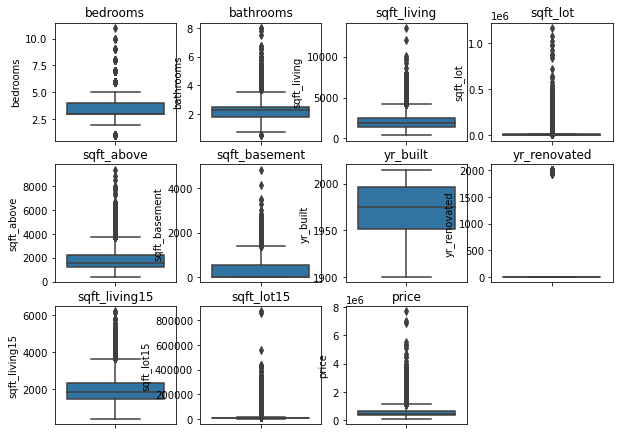

In [1042]:
boxplots_for_all_numerical_cols(data)

#### 2.1.4 Change all numeric values to integer ???

+ no, as most of the data is already numerical and some data shouldn't be (long, lat, rooms, ...)

In [1043]:
# data = all_numeric_to_int(ca_df)

<a id = "categoricals"></a>
### 2.3 Categorical columns

#### 2.2.1 Check for NaNs

In [1044]:
nan_values_of_all_columns(data[split_column_names_by(data)[1]])

id 0
date 0
floors 0
waterfront 0
view 0
condition 0
grade 0
zipcode 0
lat 0
long 0
month_sold 0


+ create month_sold column

In [1045]:
data["month_sold"] = list(map(extract_month, data["date"]))

In [1046]:
data["month_sold"] = data["month_sold"].astype('category')

<a id="drop_columns"></a>
### 2.4 Create modelling dataframe by dropping some columns

In [1047]:
data.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price', 'month_sold'],
      dtype='object')

In [1048]:
model_df = data.copy()
model_df.drop(["id", "date", "lat", "long", "yr_renovated"], axis=1, inplace=True)

In [ ]:
data.

In [1049]:
model_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,price,month_sold
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,1340,5650,221900,10
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,1690,7639,538000,12
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,2720,8062,180000,2
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,1360,5000,604000,12
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,1800,7503,510000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,98103,1530,1509,360000,5
21593,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,98146,1830,7200,400000,2
21594,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,98144,1020,2007,402101,6
21595,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,98027,1410,1287,400000,1


In [1050]:
# model_df[model_df["price"] < 4000000]

#### 2.2.3 All strings to lower case

In [1051]:
# ca_df = all_strings_lowercase(ca_df)

[top of notebook](#top)

## 3. Adjust the DataFrame to fine tune the model

<a id="df_setup"></a>
### 3.1 Dataframe set up
Create a copy of the cleaned DataFrame to avoid multiple new runs of the cleaning process

In [1197]:
this_model = model_df.copy()
split_column_names_by(this_model)[1]

['floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode', 'month_sold']

In [1198]:
#this_model

**In the follwoing cell, adjust the DataFrame**

In [1199]:
# this_model.drop(this_model.index[list(data[data["sqft_living"] > 10000].index)], inplace=True)
this_model = this_model[this_model["price"] < 4000000]

Select scaling method by (un)commenting contents of the following cell:

In [1200]:
scaler = "standard_scaler"
# scaler = "quantile_transformer"
# scaler = "power_transformator"  # not completely tested


Select the size of the test set

In [1201]:
test_set_size = .30

Select further options:

In [1202]:
show_boxplots_for_all_numerical = True
show_histograms_for_normalized_cols = False
show_hist_for_X = False
print_model_data = False
show_prediction_plots = True

When complete, run code and find the result under [output](#result).

#### 3.1.1 Numerical

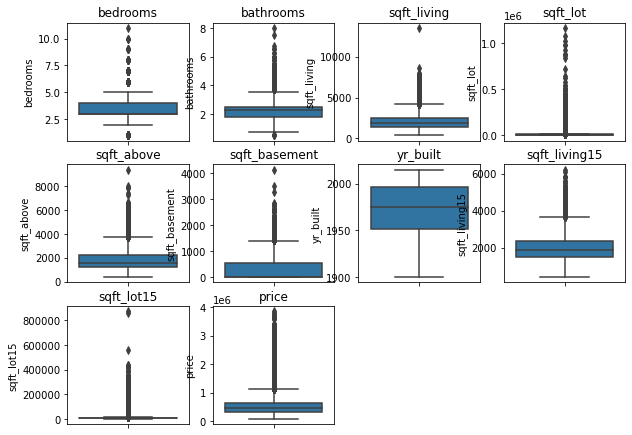

In [1203]:
if show_boxplots_for_all_numerical:
    boxplots_for_all_numerical_cols(split_df_by(this_model)[0])

In [1204]:
if show_histograms_for_normalized_cols:
    for col in split_column_names_by(this_model)[0]:
        plot_hist_normalized(this_model[col], scaler)

#### 3.1.2 Categorical

In [1205]:
categoricals_features= this_model.select_dtypes("category")


In [1206]:
cat_cols=pd.get_dummies(categoricals_features, drop_first=True)

#### 3.1.3 X-y split

In [1207]:
X=this_model.drop("price", axis=1)
y=this_model["price"]

In [1208]:
X=X._get_numeric_data()
# X

In [1209]:
if show_hist_for_X:
    X.hist(figsize=(14,14))

**Concat dummies to numeric standardized**

In [1210]:
X = pd.concat([X,cat_cols],axis=1)
# X

#### 3.1.4 Data splitting

In [1211]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_set_size,random_state=42)

#### 3.1.5 Standardize
+ Build scaling parameters on training set (mean variance) → more data as majority of datapoints of sample<br>(1 - *test_sample_size*) <br>



In [1212]:
if scaler == "quantile_transformer":
    scaler_used = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(X_train)
elif scaler == "power_transformator":
    scaler_used = PowerTransformer().fit(X_train)
else:
    scaler_used = StandardScaler().fit(X_train)

+ Apply on training set

In [1213]:
X_train_scaled=scaler_used.transform(X_train)

+ as well as on test set (same std_scaler but generated by a bigger set of values), same scaling param's as x_train

In [1214]:
X_test_scaled=scaler_used.transform(X_test)

#### 3.1.6 Modeling using Statsmodels

In [1215]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
if print_model_data:
    print(print_model)

In [1216]:
predictions_test

array([272803.53180917, 318524.8329239 , 168568.96845115, ...,
       588645.46971337, 692152.08148344, 691296.20155489])

#### 3.1.7 Modeling using Scikit Learn

##### 3.1.7.1 Model fitting

In [1217]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

##### 3.1.7.2 Parameters of model

In [1218]:
model.coef_

array([ -9289.53476969,  22726.84647934,  63544.60267118,  10126.05248875,
        63960.70228082,  10884.63757068, -13447.12734365,  14753.08905658,
        -2963.42180005,  -3176.72809558, -12913.47635467,   1746.55239396,
       -11571.64870559,    910.46372989,  40771.91146229,  12292.20765859,
        13148.85187881,  24810.93115501,  39115.28742844,   3006.15143879,
        19266.00379249,  27668.53901537,  29948.56748449,  -4102.3958203 ,
       -15383.99287342, -40029.64106636, -62848.19318063, -45880.9854322 ,
        -7013.0148183 ,  22889.75226412,  40351.81634821,  31729.96520514,
        29415.59388902,    900.51026183,  -1345.8557394 ,  91701.70746862,
        26029.30242723,  38116.20414334,  21171.14251424,  29350.45718418,
         4201.97052847,  12240.20990383,   7111.73244526,   8873.65267102,
        -1270.03409463,  -5001.98597776,  10029.89822706,  23693.6724755 ,
        15397.13191799,  26715.98954665,    866.33730302,   1481.79568275,
          596.24498903,  

In [1219]:
# print(list(zip(model.coef_, X_train.columns)))

In [1220]:
coef_dict = {}
for coef, feat in list(zip(model.coef_, X.columns)):
    coef_dict[feat] = abs(coef)

In [1221]:
coef_dict_rev = {}
for coef, feat in list(zip(model.coef_, X.columns)):
    coef_dict_rev[str(abs(coef))] = feat

In [1222]:
coef_df = pd.DataFrame(coef_dict.items())
print(coef_dict)

{'bedrooms': 9289.534769691072, 'bathrooms': 22726.846479338332, 'sqft_living': 63544.60267117777, 'sqft_lot': 10126.05248875168, 'sqft_above': 63960.702280822814, 'sqft_basement': 10884.637570678857, 'yr_built': 13447.127343645912, 'sqft_living15': 14753.089056575427, 'sqft_lot15': 2963.421800049451, 'floors_1.5': 3176.7280955795977, 'floors_2.0': 12913.476354669685, 'floors_2.5': 1746.5523939633613, 'floors_3.0': 11571.648705586804, 'floors_3.5': 910.463729889233, 'waterfront_1': 40771.91146228916, 'view_1': 12292.207658586016, 'view_2': 13148.85187881022, 'view_3': 24810.93115501038, 'view_4': 39115.28742844052, 'condition_2': 3006.151438789897, 'condition_3': 19266.003792494295, 'condition_4': 27668.539015374186, 'condition_5': 29948.567484487954, 'grade_4': 4102.3958202962085, 'grade_5': 15383.992873419687, 'grade_6': 40029.641066364515, 'grade_7': 62848.193180631635, 'grade_8': 45880.98543220331, 'grade_9': 7013.014818302495, 'grade_10': 22889.752264124916, 'grade_11': 40351.8163

<AxesSubplot:xlabel='0', ylabel='1'>

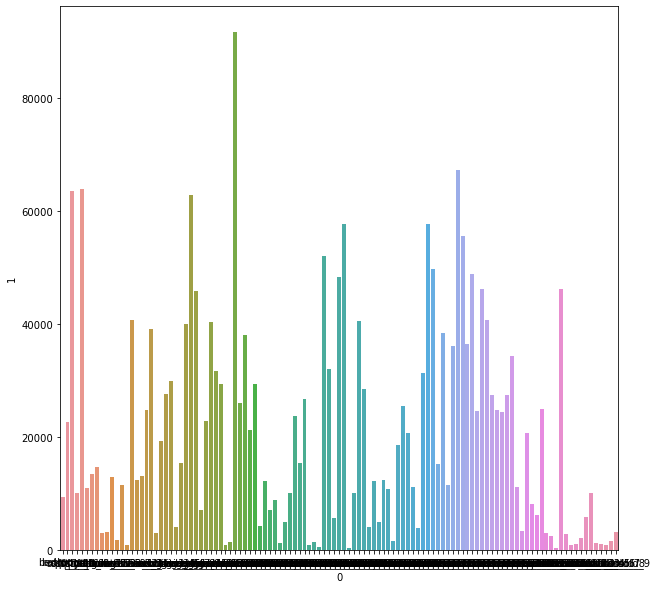

In [1223]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=coef_df, x=0, y=1)

In [1224]:
model.intercept_

536663.2939307698

In [1225]:
model.score(X_test_scaled,y_test)

0.8422839232890419

##### 3.1.7.3 Making prediction

In [1226]:
y_pred=model.predict(X_test_scaled)

In [1227]:
# y_test

In [1228]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

##### 3.1.7.4 Plots

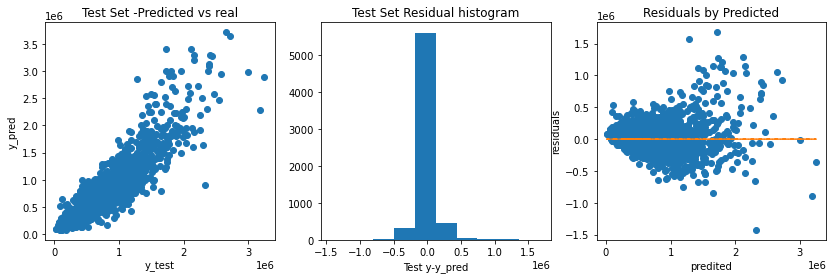

In [1229]:
if show_prediction_plots:
    fig, ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].plot(y_pred, y_test, 'o')
    ax[0].set_xlabel("y_test")
    ax[0].set_ylabel("y_pred")
    ax[0].set_title("Test Set -Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[1].hist(y_test - y_pred)
    ax[1].set_xlabel("Test y-y_pred")
    ax[1].set_title("Test Set Residual histogram")

    ax[2].plot(y_pred,y_test - y_pred,"o")
    ax[2].set_xlabel("predited")
    ax[2].set_ylabel("residuals")
    ax[2].set_title("Residuals by Predicted")
    ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

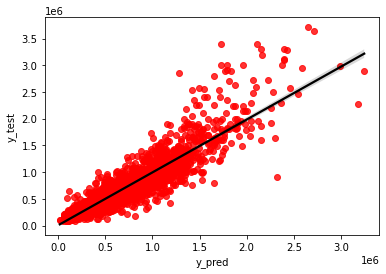

In [1230]:
if show_prediction_plots:
    sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

##### 3.1.7.5 Error metrics Test

In [1231]:
mse_test = mse(y_test,y_pred)
mae_test = mae(y_test,y_pred)

In [1232]:
r2_test=r2_score(y_test,y_pred)


In [1233]:
adj_r2_test= 1 - (1-r2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)


##### 3.1.7.6 Error metrics Train

In [1234]:
y_pred=model.predict(X_train_scaled)

In [1235]:
mse_train = mse(y_train,y_pred)
mae_train = mae(y_train,y_pred)

In [1236]:
r2_train=r2_score(y_train,y_pred)


In [1237]:
adj_r2_train= 1 - (1-r2_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)


***

<a id ="result"> </a>
### 3.2 Result Output

In [1238]:
print(f"Adjusted Dataset contains {round(len(this_model)/len(data)*100,2)} % of original data points ({len(this_model)} out of {len(data)}).")
print("")
print("Error Metrics Test Set:\n")
print("         MSE =", round(mse_test, 4),"\n")
print("         MAE =", round(mae_test, 4),"\n")
print("          R² =", round(r2_test, 4),"\n")
print(" Adjusted R² =", round(adj_r2_test, 4),"\n")
print("\n---\n")
print("Error Metrics Train Set:","\n")
print("         MSE =", round(mse_train, 4),"\n")
print("         MAE =", round(mae_train, 4),"\n")
print("          R² =", round(r2_train, 4),"\n")
print(" Adjusted R² =", round(adj_r2_train, 4),"\n")

Adjusted Dataset contains 99.94 % of original data points (21585 out of 21597).

Error Metrics Test Set:

         MSE = 19984899848.4694 

         MAE = 86760.7165 

          R² = 0.8423 

 Adjusted R² = 0.8395 


---

Error Metrics Train Set: 

         MSE = 19103684127.7876 

         MAE = 85703.2239 

          R² = 0.8391 

 Adjusted R² = 0.8379 



Change DataFrame [set up](#df_setup) here.

[top of notebook](#top)

<a id='findings'> </a>
## 4. Findings


### 4.1 No further adjustments

Adjusted Dataset contains 100.0 % of original data points (21597 out of 21597).

Error Metrics Test Set:

         MSE = 24329464452.6043 

         MAE = 88858.3318 

          R² = 0.8165 

 Adjusted R² = 0.8133 


---

Error Metrics Train Set: 

         MSE = 21290561287.0931 

         MAE = 87901.8305 

          R² = 0.8434 

 Adjusted R² = 0.8422 


### 4.2 Excluding houses with sales prices > 4 Mio

`this_model = this_model[this_model["price"] < 4000000]`

Adjusted Dataset contains 99.94 % of original data points (21585 out of 21597).

Error Metrics Test Set:

         MSE = 19984899848.4694 

         MAE = 86760.7165 

          R² = 0.8423 

 Adjusted R² = 0.8395 


---

Error Metrics Train Set: 

         MSE = 19103684127.7876 

         MAE = 85703.2239 

          R² = 0.8391 

 Adjusted R² = 0.8379 